# Discount Dependency in RetailCo Net Revenue
This project analyzes sales transaction data from RetailCo with the objective of understanding how discounts influence net revenue across products, stores, employees, customer segments, and time. Rather than treating discounts as a secondary attribute, the analysis places discount dependency at the center of the revenue evaluation.

The project focuses on comparing discounted and non discounted net revenue across multiple dimensions, identifying consistent patterns, deviations from expected behavior, and segments where discount dependency behaves differently. Special attention is given to wholesale customers, whose purchasing behavior is often expected to generate higher revenue per customer, allowing for a direct comparison between expectation and observed outcomes.

## Data Source
The dataset used for this analysis was downloaded from https://www.kaggle.com/datasets/pramudyadika/retailco-sales-transactions-dataset.


In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

con = duckdb.connect()

## Load Data
The dataset is loaded from CSV files into DuckDB tables. The analysis expects the CSV files to be available in the working directory with the following names:
- retailco_transactions_data.csv
- retailco_customer_data.csv
- retailco_store_data.csv
- retailco_user_access_log.csv


In [2]:
# Load data from CSV into DuckDB tables
con.execute("CREATE OR REPLACE TABLE transactions AS SELECT * FROM read_csv_auto('retailco_transactions_data.csv')")
con.execute("CREATE OR REPLACE TABLE customers    AS SELECT * FROM read_csv_auto('retailco_customer_data.csv')")
con.execute("CREATE OR REPLACE TABLE stores       AS SELECT * FROM read_csv_auto('retailco_store_data.csv')")
con.execute("CREATE OR REPLACE TABLE users        AS SELECT * FROM read_csv_auto('retailco_user_access_log.csv')")


## Metric Definitions
Net revenue is defined as gross revenue minus discount amount. Each transaction is classified as discounted or non discounted based on whether discount amount is greater than zero. The analysis uses a unified analytical view that joins transactions to customer, store, and user attributes.


In [3]:
# Create a unified analytical view
con.execute("""
CREATE OR REPLACE VIEW sales AS
SELECT
    t.*,
    c.customer_type,
    s.store_name,
    u.user_name,
    (t.gross_amount - t.discount_amount) AS net_revenue,
    CASE WHEN t.discount_amount > 0 THEN 'Discounted' ELSE 'No Discount' END AS discount_flag,
    COALESCE(
        try_cast(t.invoice_date AS DATE),
        try_cast(t.posting_date AS DATE)
    ) AS sale_date
FROM transactions t
LEFT JOIN customers c ON t.customer_id = c.customer_id
LEFT JOIN stores s ON t.store_id = s.store_id
LEFT JOIN users u ON t.created_by = u.user_id
""")


## Product Analysis
This section identifies the products with the highest net revenue and shows how much of each product's net revenue comes from discounted versus non discounted transactions. A stacked bar chart is used to show both total net revenue and its composition in a single view.


In [4]:
product_df = con.execute("""
SELECT
    product_id,
    SUM(CASE WHEN discount_flag='Discounted' THEN net_revenue ELSE 0 END) AS discounted_net_revenue,
    SUM(CASE WHEN discount_flag='No Discount' THEN net_revenue ELSE 0 END) AS no_discount_net_revenue,
    SUM(net_revenue) AS net_revenue
FROM sales
GROUP BY product_id
ORDER BY net_revenue DESC
""").df()

top_products = product_df.head(10).copy()
top_products


,product_id,discounted_net_revenue,no_discount_net_revenue,net_revenue
0,P015,38063100.0,7570000.0,45633100.0
1,P018,39712700.0,3340000.0,43052700.0
2,P012,39960900.0,2588000.0,42548900.0
3,P020,38513200.0,0.0,38513200.0
4,P013,36712700.0,990000.0,37702700.0
5,P016,34541500.0,2780000.0,37321500.0
6,P023,33756000.0,2535000.0,36291000.0
7,P007,33193900.0,1892000.0,35085900.0
8,P025,31089100.0,3534000.0,34623100.0
9,P021,33539100.0,990000.0,34529100.0


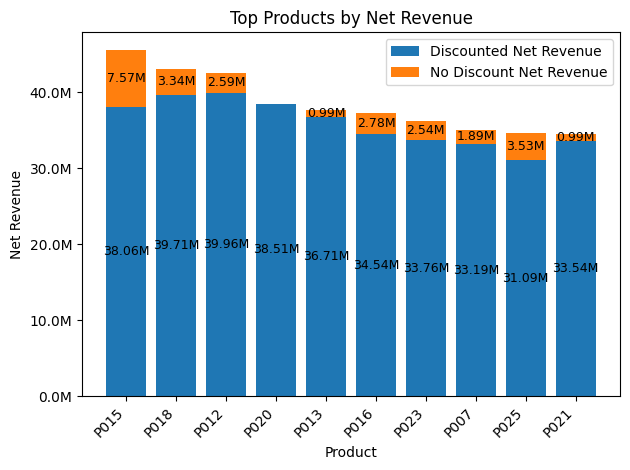

In [5]:
plt.figure()
x = top_products['product_id'].astype(str).tolist()

discounted = top_products['discounted_net_revenue'].tolist()
no_discount = top_products['no_discount_net_revenue'].tolist()

ax = plt.gca()
ax.bar(x, discounted, label='Discounted Net Revenue');  # bottom
ax.bar(x, no_discount, bottom=discounted, label='No Discount Net Revenue');  # top

ax.set_title('Top Products by Net Revenue')
ax.set_xlabel('Product')
ax.set_ylabel('Net Revenue')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

for i, (b, t) in enumerate(zip(discounted, no_discount)):
    if b:
        ax.text(i, b/2, f'{b/1_000_000:.2f}M', ha="center", va="center", fontsize=9)
    if t:
        ax.text(i, b + t/2, f'{t/1_000_000:.2f}M', ha="center", va="center", fontsize=9)

ax.legend()
plt.tight_layout()
plt.show()


In the chart above, each product’s total net revenue is split into the portion generated from discounted transactions and the portion generated from non discounted transactions. This makes it easier to see whether top performing products rely primarily on discounts or whether most revenue is generated without discounts.

Across the top products, net revenue is predominantly driven by discounted transactions. Using 90% discounted net revenue as a practical reference reference point, most products exceed this level.

P015 is the highest net revenue product but also the main exception to the 90% reference level, with only 83.41% of its net revenue coming from discounted sales. P025 is the only other product below the baseline at 89.79%. At the opposite end, P020 is entirely discount driven, with 100% of net revenue coming from discounted sales.

Overall, this section reinforces the consistent pattern observed across the analysis: net revenue is predominantly driven by discounted transactions, with only limited variation across products.

## Store Analysis
This section ranks stores by net revenue and shows the share of net revenue coming from discounted versus non discounted transactions. It then drills into the top products within each store by net revenue, using a stacked bar chart to show the discount composition for each product.


In [6]:
store_df = con.execute("""
SELECT
    store_name,
    SUM(CASE WHEN discount_flag='Discounted' THEN net_revenue ELSE 0 END) AS discounted_net_revenue,
    SUM(CASE WHEN discount_flag='No Discount' THEN net_revenue ELSE 0 END) AS no_discount_net_revenue,
    SUM(net_revenue) AS net_revenue
FROM sales
GROUP BY store_name
ORDER BY net_revenue DESC
""").df()

top_stores = store_df.head(5).copy()
store_df


,store_name,discounted_net_revenue,no_discount_net_revenue,net_revenue
0,RetailCo Surabaya Center,166295400.0,15223000.0,181518400.0
1,RetailCo Medan Square,151293100.0,14282000.0,165575100.0
2,RetailCo Plaza Jakarta,156976700.0,7550000.0,164526700.0
3,RetailCo Mall Bandung,147373900.0,9317000.0,156690900.0
4,RetailCo Denpasar Point,144176900.0,9757000.0,153933900.0


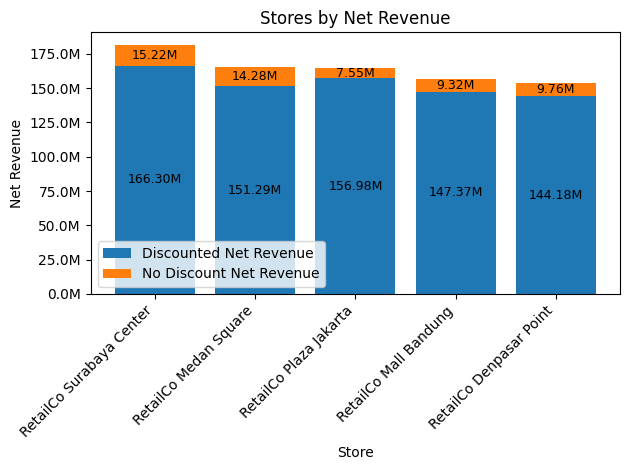

In [7]:
plt.figure()
x = store_df['store_name'].astype(str).tolist()

discounted = store_df['discounted_net_revenue'].tolist()
no_discount = store_df['no_discount_net_revenue'].tolist()

ax = plt.gca()
ax.bar(x, discounted, label='Discounted Net Revenue');  # bottom
ax.bar(x, no_discount, bottom=discounted, label='No Discount Net Revenue');  # top

ax.set_title('Stores by Net Revenue')
ax.set_xlabel('Store')
ax.set_ylabel('Net Revenue')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

for i, (b, t) in enumerate(zip(discounted, no_discount)):
    if b:
        ax.text(i, b/2, f'{b/1_000_000:.2f}M', ha="center", va="center", fontsize=9)
    if t:
        ax.text(i, b + t/2, f'{t/1_000_000:.2f}M', ha="center", va="center", fontsize=9)

ax.legend()
plt.tight_layout()
plt.show()


At the store level, the discount driven pattern remains consistent. All stores generate more than 90% of their net revenue from discounted sales, so the 90% reference point remains a useful reference level when comparing locations.

In [8]:
# Top 3 products by Net Revenue for each of the top 5 stores
top_store_names = top_stores['store_name'].tolist()
top_store_names


['RetailCo Surabaya Center',
 'RetailCo Medan Square',
 'RetailCo Plaza Jakarta',
 'RetailCo Mall Bandung',
 'RetailCo Denpasar Point']

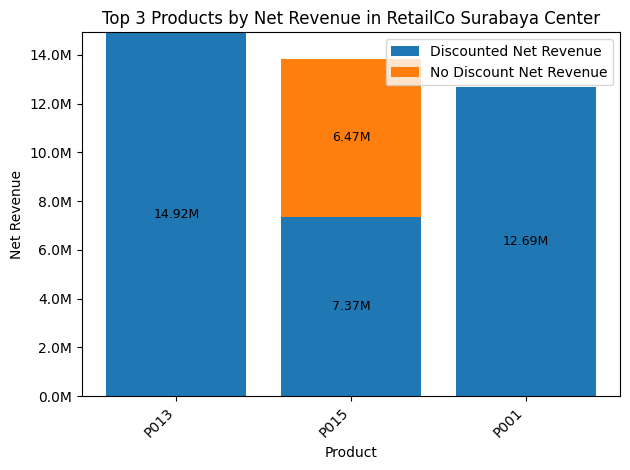

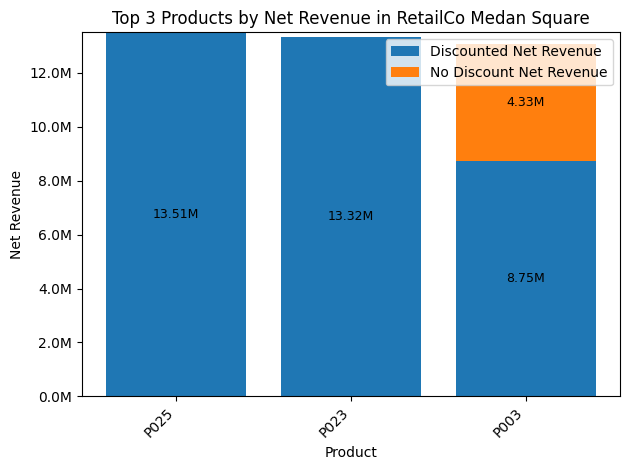

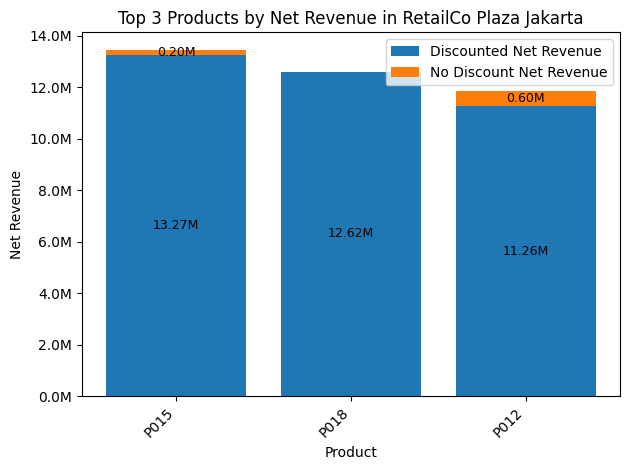

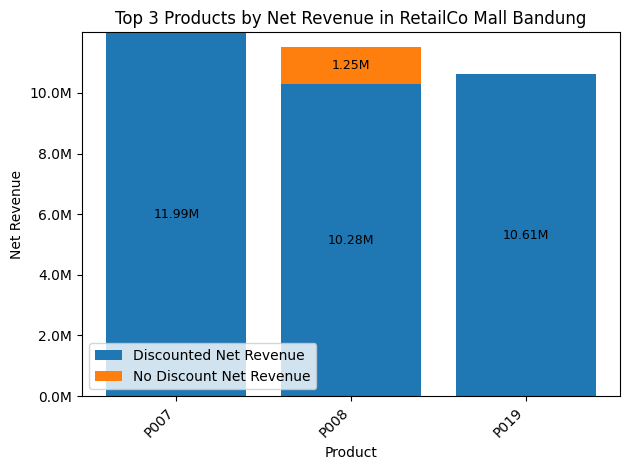

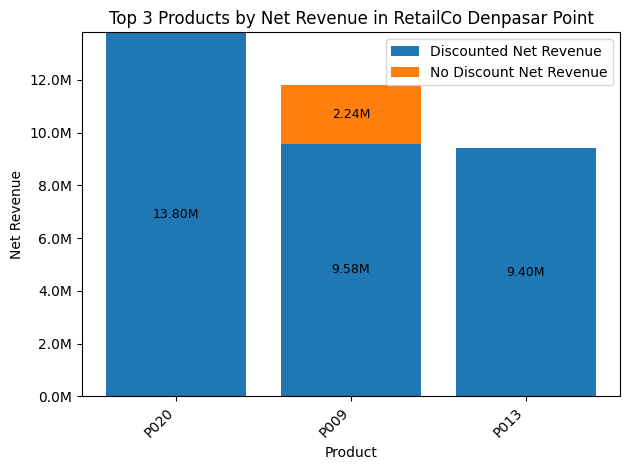

In [9]:
for store_name in top_store_names:
    df_store_products = con.execute("""
    WITH store_products AS (
        SELECT
            store_name,
            product_id,
            SUM(CASE WHEN discount_flag='Discounted' THEN net_revenue ELSE 0 END) AS discounted_net_revenue,
            SUM(CASE WHEN discount_flag='No Discount' THEN net_revenue ELSE 0 END) AS no_discount_net_revenue,
            SUM(net_revenue) AS net_revenue
        FROM sales
        WHERE store_name = ?
        GROUP BY store_name, product_id
    )
    SELECT *
    FROM store_products
    ORDER BY net_revenue DESC
    LIMIT 3
    """, [store_name]).df()

    plt.figure()
    x = df_store_products['product_id'].astype(str).tolist()
    discounted = df_store_products['discounted_net_revenue'].tolist()
    no_discount = df_store_products['no_discount_net_revenue'].tolist()

    ax = plt.gca()
    ax.bar(x, discounted, label='Discounted Net Revenue');  # bottom
    ax.bar(x, no_discount, bottom=discounted, label='No Discount Net Revenue');  # top

    ax.set_title(f'Top 3 Products by Net Revenue in {store_name}')
    ax.set_xlabel('Product')
    ax.set_ylabel('Net Revenue')
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    for i, (b, t) in enumerate(zip(discounted, no_discount)):
        if b:
            ax.text(i, b/2, f'{b/1_000_000:.2f}M', ha='center', va='center', fontsize=9)
        if t:
            ax.text(i, b + t/2, f'{t/1_000_000:.2f}M', ha='center', va='center', fontsize=9)

    ax.legend()
    plt.tight_layout()
    plt.show()


Looking at the top three products within each store, a recurring structure appears. In most stores, two products are fully discount driven, while one product deviates materially from the 90% reference point.

Surabaya Center shows the strongest deviation, where P015 has only 53.23% of net revenue coming from discounted sales, while P001 and P003 are fully discounted. Medan Square follows a similar pattern: P023 and P025 are fully discounted, while P003 falls to 66.88%.

Plaza Jakarta is more uniform, with all top products above 90% and P018 fully discounted. Mall Bandung has P007 and P019 fully discounted, while P008 is slightly below the reference level at 89.20%. Denpasar Point has P013 and P020 fully discounted, with P009 below the baseline at 81.04%.

Overall, the store level results align with the broader findings, showing that discount driven net revenue dominates across locations.

## Employee Analysis
This section ranks employees by net revenue and shows how much of their net revenue comes from discounted versus non discounted transactions. It then drills into each top employee’s three highest net revenue products and shows the discount composition for those products.


In [10]:
employee_df = con.execute("""
SELECT
    user_name,
    SUM(CASE WHEN discount_flag='Discounted' THEN net_revenue ELSE 0 END) AS discounted_net_revenue,
    SUM(CASE WHEN discount_flag='No Discount' THEN net_revenue ELSE 0 END) AS no_discount_net_revenue,
    SUM(net_revenue) AS net_revenue
FROM sales
GROUP BY user_name
ORDER BY net_revenue DESC
""").df()

top_employees = employee_df.head(8).copy()
employee_df.head(15)


,user_name,discounted_net_revenue,no_discount_net_revenue,net_revenue
0,Citra,106780500.0,8612000.0,115392500.0
1,Hanif,105005400.0,9808000.0,114813400.0
2,Eka,102490900.0,5073000.0,107563900.0
3,Fajar,94429100.0,12444000.0,106873100.0
4,Bella,103458600.0,1838000.0,105296600.0
5,Andika,91153700.0,6370000.0,97523700.0
6,Gita,82790900.0,7661000.0,90451900.0
7,Dwi,80006900.0,4323000.0,84329900.0


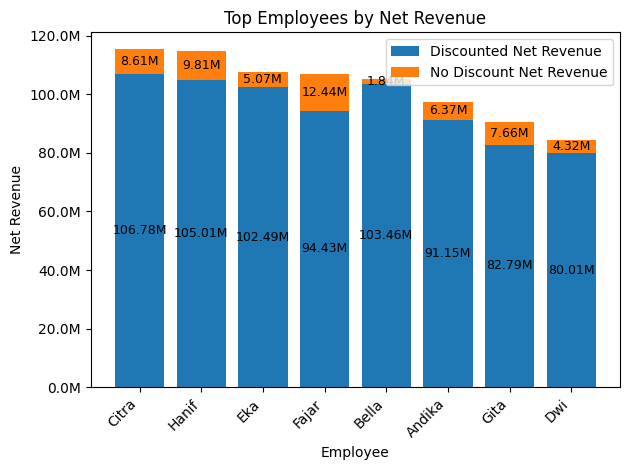

In [11]:
plt.figure()
x = top_employees['user_name'].astype(str).tolist()

discounted = top_employees['discounted_net_revenue'].tolist()
no_discount = top_employees['no_discount_net_revenue'].tolist()

ax = plt.gca()
ax.bar(x, discounted, label='Discounted Net Revenue');  # bottom
ax.bar(x, no_discount, bottom=discounted, label='No Discount Net Revenue');  # top

ax.set_title('Top Employees by Net Revenue')
ax.set_xlabel('Employee')
ax.set_ylabel('Net Revenue')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

for i, (b, t) in enumerate(zip(discounted, no_discount)):
    if b:
        ax.text(i, b/2, f'{b/1_000_000:.2f}M', ha="center", va="center", fontsize=9)
    if t:
        ax.text(i, b + t/2, f'{t/1_000_000:.2f}M', ha="center", va="center", fontsize=9)

ax.legend()
plt.tight_layout()
plt.show()


Across the top employees, net revenue is again predominantly driven by discounted transactions. Most employees exceed the 90% reference point, with one small exception: Fajar, at 88.36% discounted net revenue.

In [12]:
top_employee_names = top_employees['user_name'].tolist()
top_employee_names


['Citra', 'Hanif', 'Eka', 'Fajar', 'Bella', 'Andika', 'Gita', 'Dwi']

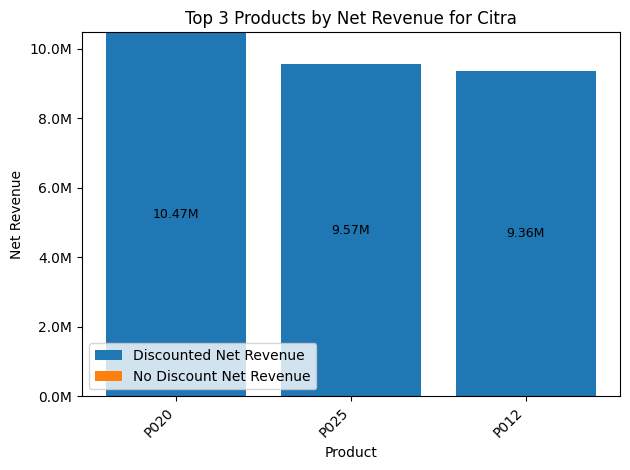

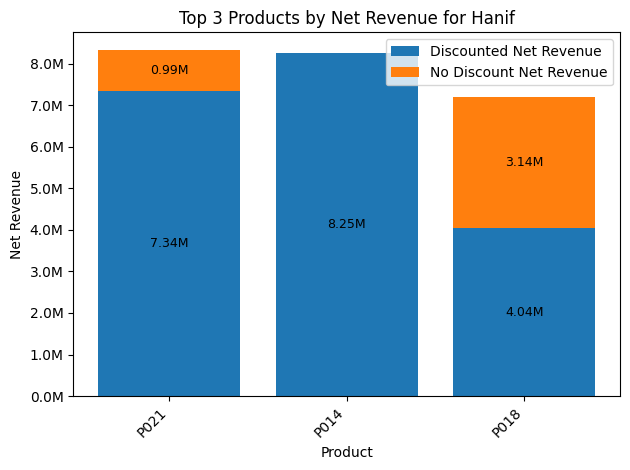

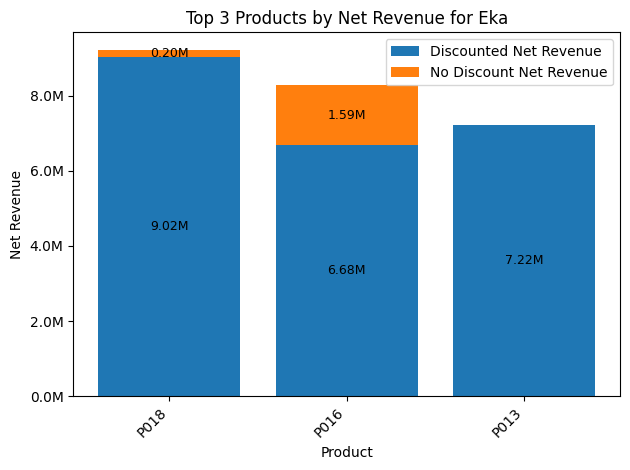

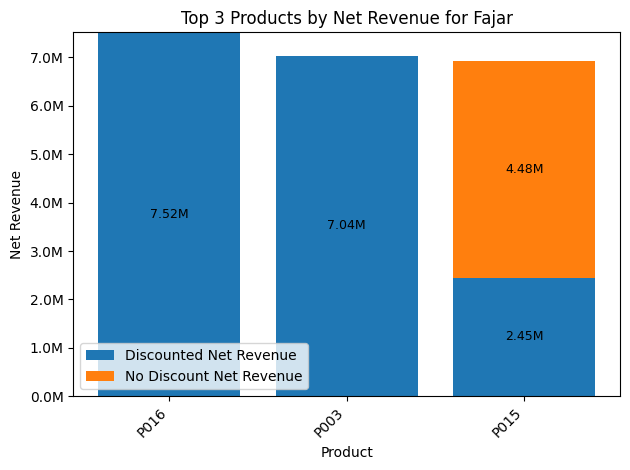

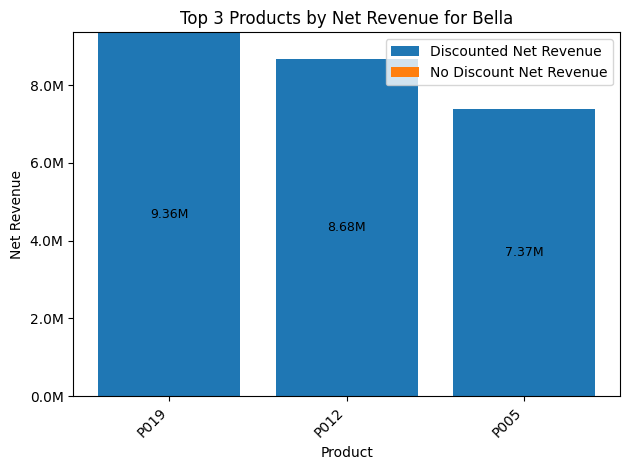

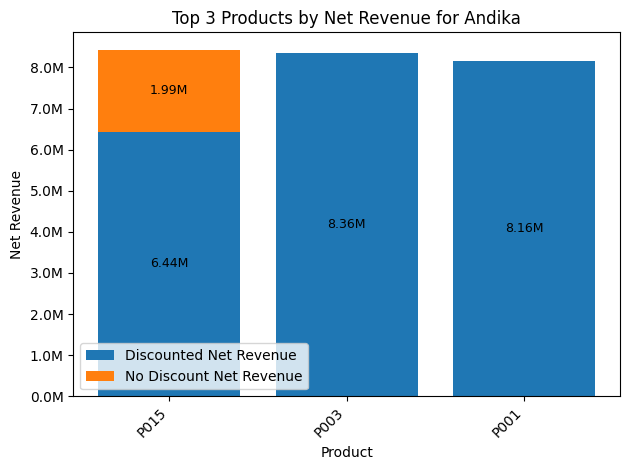

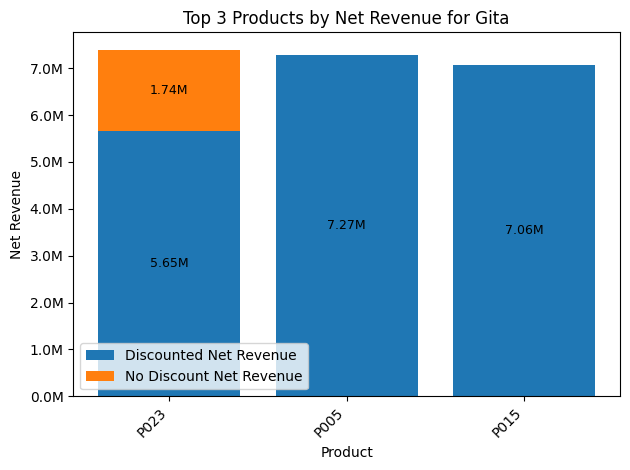

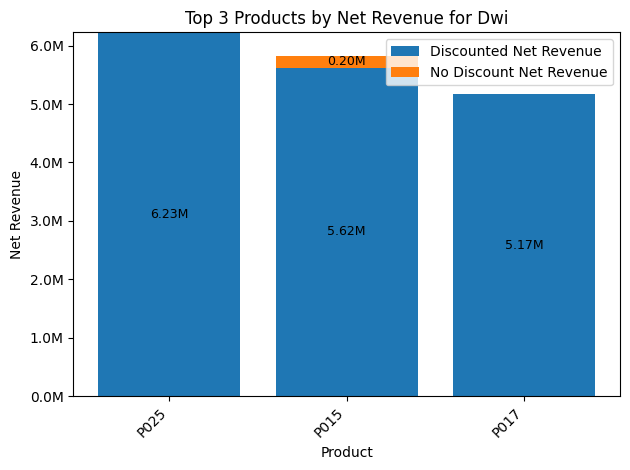

In [13]:
for user_name in top_employee_names:
    df_emp_products = con.execute("""
    WITH emp_products AS (
        SELECT
            user_name,
            product_id,
            SUM(CASE WHEN discount_flag='Discounted' THEN net_revenue ELSE 0 END) AS discounted_net_revenue,
            SUM(CASE WHEN discount_flag='No Discount' THEN net_revenue ELSE 0 END) AS no_discount_net_revenue,
            SUM(net_revenue) AS net_revenue
        FROM sales
        WHERE user_name = ?
        GROUP BY user_name, product_id
    )
    SELECT *
    FROM emp_products
    ORDER BY net_revenue DESC
    LIMIT 3
    """, [user_name]).df()

    plt.figure()
    x = df_emp_products['product_id'].astype(str).tolist()
    discounted = df_emp_products['discounted_net_revenue'].tolist()
    no_discount = df_emp_products['no_discount_net_revenue'].tolist()

    ax = plt.gca()
    ax.bar(x, discounted, label='Discounted Net Revenue');  # bottom
    ax.bar(x, no_discount, bottom=discounted, label='No Discount Net Revenue');  # top

    ax.set_title(f'Top 3 Products by Net Revenue for {user_name}')
    ax.set_xlabel('Product')
    ax.set_ylabel('Net Revenue')
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    for i, (b, t) in enumerate(zip(discounted, no_discount)):
        if b:
            ax.text(i, b/2, f'{b/1_000_000:.2f}M', ha='center', va='center', fontsize=9)
        if t:
            ax.text(i, b + t/2, f'{t/1_000_000:.2f}M', ha='center', va='center', fontsize=9)

    ax.legend()
    plt.tight_layout()
    plt.show()


When expanding to the top three products for each employee, discount reliance varies strongly at the product level.

Citra’s top products, P020, P025, and P012, are entirely discount driven. Hanif shows a mixed profile: P014 is fully discounted, P021 is slightly below the 90% reference point at 88.12%, and P018 deviates further at 56.29%.

Eka combines one fully discounted product, P013, one product above 90%, P018, and one below the reference level, P016, at 80.76%. Fajar shows the most pronounced deviation: P016 and P003 are fully discounted, while P015 generates only 35.35% of net revenue from discounted transactions.

Bella’s top products are fully discounted. Andika combines two fully discounted products with P015 at 76.38%. Gita combines two fully discounted products with P023 at 76.44%. Dwi aligns closely with the dominant pattern, with two fully discounted products and P015 remaining above the baseline at 96.58%.

At the employee level, the same structural pattern persists, indicating that net revenue outcomes remain largely dependent on discounted sales.

## Customer Analysis
This section compares net revenue across customer types and shows how much net revenue for each segment is associated with discounted versus non discounted transactions.

Retail and online customers primarily represent end consumers. Online reflects a digital sales channel rather than a distinct economic profile. Wholesale customers are expected to represent resellers, typically characterized by fewer clients, higher transaction values, and more irregular purchasing patterns.

In [14]:
customer_type_df = con.execute("""
SELECT
    customer_type,
    SUM(CASE WHEN discount_flag='Discounted' THEN net_revenue ELSE 0 END) AS discounted_net_revenue,
    SUM(CASE WHEN discount_flag='No Discount' THEN net_revenue ELSE 0 END) AS no_discount_net_revenue,
    SUM(net_revenue) AS net_revenue
FROM sales
GROUP BY customer_type
ORDER BY net_revenue DESC
""").df()

customer_type_df


,customer_type,discounted_net_revenue,no_discount_net_revenue,net_revenue
0,Retail,304821800.0,23934000.0,328755800.0
1,Online,229594200.0,23145000.0,252739200.0
2,Wholesale,231700000.0,9050000.0,240750000.0


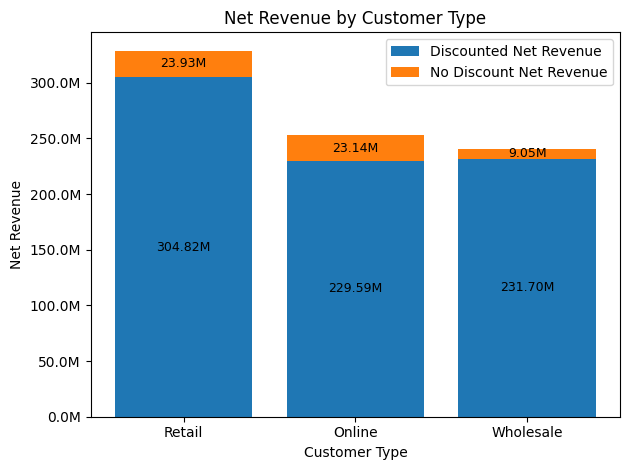

In [15]:
plt.figure()
x = customer_type_df['customer_type'].astype(str).tolist()

discounted = customer_type_df['discounted_net_revenue'].tolist()
no_discount = customer_type_df['no_discount_net_revenue'].tolist()

ax = plt.gca()
ax.bar(x, discounted, label='Discounted Net Revenue');  # bottom
ax.bar(x, no_discount, bottom=discounted, label='No Discount Net Revenue');  # top

ax.set_title('Net Revenue by Customer Type')
ax.set_xlabel('Customer Type')
ax.set_ylabel('Net Revenue')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))

for i, (b, t) in enumerate(zip(discounted, no_discount)):
    if b:
        ax.text(i, b/2, f'{b/1_000_000:.2f}M', ha="center", va="center", fontsize=9)
    if t:
        ax.text(i, b + t/2, f'{t/1_000_000:.2f}M', ha="center", va="center", fontsize=9)

ax.legend()
plt.tight_layout()
plt.show()


The chart above compares customer segments in terms of total net revenue and shows whether each segment’s revenue is more dependent on discounted transactions or on non discounted sales. This helps contextualize discount reliance at the segment level before focusing on specific high impact customers.


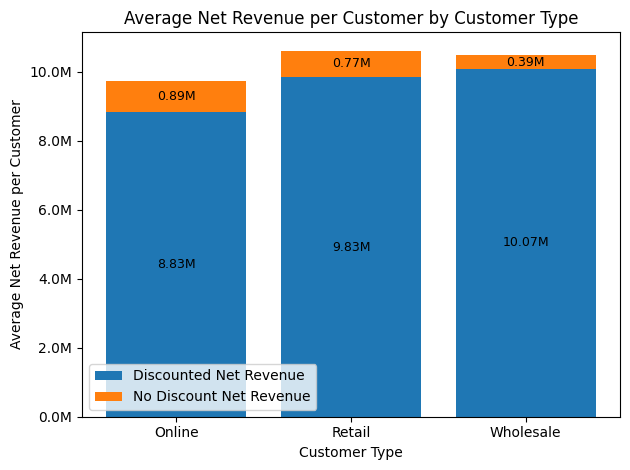

In [16]:
# Average Net Revenue per Customer by Customer Type
avg_customer_type_df = con.execute("""
WITH customer_totals AS (
    SELECT
        customer_type,
        customer_id,
        SUM(CASE WHEN discount_flag = 'Discounted' THEN net_revenue ELSE 0 END) AS discounted_net_revenue,
        SUM(CASE WHEN discount_flag = 'No Discount' THEN net_revenue ELSE 0 END) AS no_discount_net_revenue
    FROM sales
    GROUP BY customer_type, customer_id
)
SELECT
    customer_type,
    AVG(discounted_net_revenue) AS avg_discounted_net_revenue,
    AVG(no_discount_net_revenue) AS avg_no_discount_net_revenue
FROM customer_totals
GROUP BY customer_type
ORDER BY customer_type
""").df()
plt.figure()

x = avg_customer_type_df["customer_type"].astype(str).tolist()
discounted = avg_customer_type_df["avg_discounted_net_revenue"].tolist()
no_discount = avg_customer_type_df["avg_no_discount_net_revenue"].tolist()

ax = plt.gca()
ax.bar(x, discounted, label="Discounted Net Revenue")  # bottom
ax.bar(x, no_discount, bottom=discounted, label="No Discount Net Revenue")  # top

ax.set_title("Average Net Revenue per Customer by Customer Type")
ax.set_xlabel("Customer Type")
ax.set_ylabel("Average Net Revenue per Customer")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda v, _: f"{v/1_000_000:.1f}M"))

for i, (b, t) in enumerate(zip(discounted, no_discount)):
    if b:
        ax.text(i, b/2, f"{b/1_000_000:.2f}M", ha="center", va="center", fontsize=9)
    if t:
        ax.text(i, b + t/2, f"{t/1_000_000:.2f}M", ha="center", va="center", fontsize=9)

ax.legend()
plt.tight_layout()
plt.show()


Across customer segments, net revenue remains predominantly driven by discounted sales. Retail, online, and wholesale customers all generate more than 90% of net revenue from discounted transactions. wholesale customers present a slightly higher discounted share compared to retail and online segments.

From an average net revenue per customer perspective, wholesale customers are typically expected to generate higher values than retail and online customers. However, the observed results in this dataset do not fully reflect this expectation. The average net revenue per wholesale customer remains comparable to the other customer types.

Across customer segments, the analysis confirms that discounted transactions represent the primary driver of net revenue, with only modest differences between segments.

## Temporal Analysis
This section evaluates monthly net revenue and the monthly count of discounted sales. It computes the average monthly net revenue and the average monthly discounted sale count, then identifies months that are significantly above or below the average based on net revenue.


In [17]:
monthly_df = con.execute("""
SELECT
    date_trunc('month', sale_date) AS month,
    SUM(net_revenue) AS net_revenue,
    SUM(CASE WHEN discount_flag='Discounted' THEN 1 ELSE 0 END) AS discounted_sales_count
FROM sales
WHERE sale_date IS NOT NULL
GROUP BY month
ORDER BY month
""").df()

monthly_df


,month,net_revenue,discounted_sales_count
0,2024-01-01,55480900.0,41.0
1,2024-02-01,79610100.0,64.0
2,2024-03-01,62360600.0,54.0
3,2024-04-01,42659300.0,47.0
4,2024-05-01,82875600.0,67.0
5,2024-06-01,65471000.0,52.0
6,2024-07-01,81446200.0,69.0
7,2024-08-01,48683700.0,38.0
8,2024-09-01,61984100.0,48.0
9,2024-10-01,60989100.0,55.0


In [18]:
avg_monthly_net = monthly_df['net_revenue'].mean()
avg_monthly_discounted_sales = monthly_df['discounted_sales_count'].mean()

avg_monthly_net, avg_monthly_discounted_sales


(63249615.384615384, 53.61538461538461)

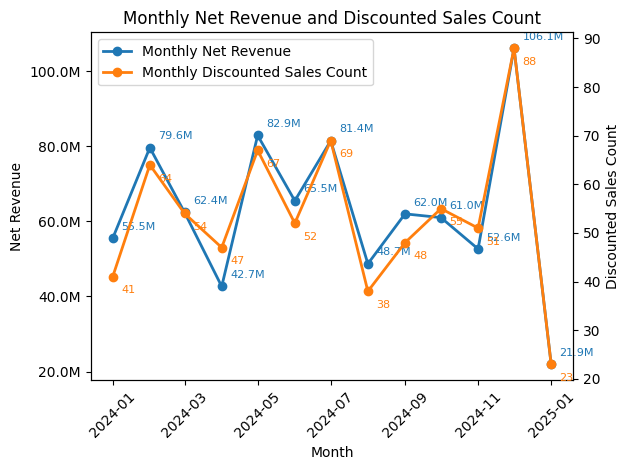

In [19]:
def fmt_m(x):
    return f"{x/1_000_000:.1f}M"

def fmt_count(x):
    if x >= 1_000_000:
        return f"{x/1_000_000:.1f}M"
    if x >= 1_000:
        return f"{x/1_000:.1f}K"
    return f"{int(x)}"

fig, ax1 = plt.subplots()

ax1.plot(
    monthly_df['month'],
    monthly_df['net_revenue'],
    label='Monthly Net Revenue',
    color='tab:blue',
    marker='o',
    markeredgecolor='tab:blue',
    markerfacecolor='tab:blue',
    linewidth=2,
)
ax1.set_xlabel('Month')
ax1.set_ylabel('Net Revenue')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M"))
ax1.tick_params(axis='x', rotation=45)

for x_val, y_val in zip(monthly_df['month'], monthly_df['net_revenue']):
    ax1.annotate(fmt_m(y_val), (x_val, y_val), textcoords="offset points", xytext=(6, 6), fontsize=8, color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(
    monthly_df['month'],
    monthly_df['discounted_sales_count'],
    label='Monthly Discounted Sales Count',
    color='tab:orange',
    marker='o',
    markeredgecolor='tab:orange',
    markerfacecolor='tab:orange',
    linewidth=2,
)
ax2.set_ylabel('Discounted Sales Count')

for x_val, y_val in zip(monthly_df['month'], monthly_df['discounted_sales_count']):
    ax2.annotate(fmt_count(y_val), (x_val, y_val), textcoords="offset points", xytext=(6, -12), fontsize=8, color='tab:orange')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Monthly Net Revenue and Discounted Sales Count')
plt.tight_layout()
plt.show()


Monthly net revenue and the volume of discounted sales are closely related throughout the entire time series, with both metrics moving together across months. One month clearly stands out from the rest of the series: December 2024 shows a substantially higher monthly net revenue compared to all other months and also records a much higher volume of discounted sales, representing an extreme peak within this consistent relationship.

From a temporal perspective, net revenue and discounted sales volume follow similar month to month variations, reinforcing the structural nature of the observed discount dependency.

## Wholesale Focus
The customer segment results show that wholesale customers in this dataset do not have a dramatically different average net revenue compared to other customer types. For that reason, the wholesale deep dive focuses only on the wholesale customers who generate net revenue far above the overall customer average.

The analysis uses the top three wholesale customers by total net revenue and compares their per customer net revenue (and its discount composition) to the overall per customer net revenue across all customers.


In [20]:
# Overall average Net Revenue per customer (all customers)
overall_customer_summary = con.execute("""
SELECT
    COUNT(DISTINCT customer_id) AS customers,
    SUM(CASE WHEN discount_flag='Discounted' THEN net_revenue ELSE 0 END) AS discounted_net_revenue,
    SUM(CASE WHEN discount_flag='No Discount' THEN net_revenue ELSE 0 END) AS no_discount_net_revenue,
    SUM(net_revenue) AS net_revenue
FROM sales
""").df()

overall_customer_summary

overall_avg_disc = float(overall_customer_summary.loc[0, 'discounted_net_revenue']) / float(overall_customer_summary.loc[0, 'customers'])
overall_avg_no_disc = float(overall_customer_summary.loc[0, 'no_discount_net_revenue']) / float(overall_customer_summary.loc[0, 'customers'])



In [21]:
# Top 3 Wholesale customers by total Net Revenue
top3_wholesale = con.execute("""
SELECT
    customer_id,
    SUM(CASE WHEN discount_flag='Discounted' THEN net_revenue ELSE 0 END) AS discounted_net_revenue,
    SUM(CASE WHEN discount_flag='No Discount' THEN net_revenue ELSE 0 END) AS no_discount_net_revenue,
    SUM(net_revenue) AS net_revenue
FROM sales
WHERE customer_type = 'Wholesale'
GROUP BY customer_id
ORDER BY net_revenue DESC
LIMIT 3
""").df()

top3_wholesale


,customer_id,discounted_net_revenue,no_discount_net_revenue,net_revenue
0,C023,16889100.0,1890000.0,18779100.0
1,C032,15387700.0,0.0,15387700.0
2,C065,13816300.0,0.0,13816300.0


In [22]:
# Build a three-bar comparison:
# 1) Top 3 Wholesale (average per customer)
# 2) All Wholesale (average per customer)
# 3) All Customers (average per customer)

# Overall (all customers)
# Values computed above in overall_customer_summary

# All Wholesale
all_wholesale_summary = con.execute("""
SELECT
    COUNT(DISTINCT customer_id) AS customers,
    SUM(CASE WHEN discount_flag = 'Discounted' THEN net_revenue ELSE 0 END) AS discounted_total,
    SUM(CASE WHEN discount_flag = 'No Discount' THEN net_revenue ELSE 0 END) AS no_discount_total
FROM sales
WHERE customer_type = 'Wholesale'
""").df()

wh_disc_total = float(all_wholesale_summary.loc[0, "discounted_total"])
wh_no_disc_total = float(all_wholesale_summary.loc[0, "no_discount_total"])
wh_customers = float(all_wholesale_summary.loc[0, "customers"])

# Top 3 Wholesale
# Since top3_wholesale already contains the necessary data, we can calculate directly from it
# Assuming top3_wholesale_summary is meant to be top3_wholesale

top3_disc_total = float(top3_wholesale['discounted_net_revenue'].sum())
top3_no_disc_total = float(top3_wholesale['no_discount_net_revenue'].sum())
top3_customers = len(top3_wholesale)

compare_df = pd.DataFrame({
    "group": ["Top 3 Wholesale", "All Wholesale", "All Customers"],
    "discounted_net_revenue": [
        top3_disc_total / top3_customers if top3_customers else 0.0,
        wh_disc_total / wh_customers if wh_customers else 0.0,
        overall_avg_disc
    ],
    "no_discount_net_revenue": [
        top3_no_disc_total / top3_customers if top3_customers else 0.0,
        wh_no_disc_total / wh_customers if wh_customers else 0.0,
        overall_avg_no_disc
    ],
})

compare_df

,group,discounted_net_revenue,no_discount_net_revenue
0,Top 3 Wholesale,1.536437e+07,630000.00000
1,All Wholesale,1.007391e+07,393478.26087
2,All Customers,9.576450e+06,701612.50000


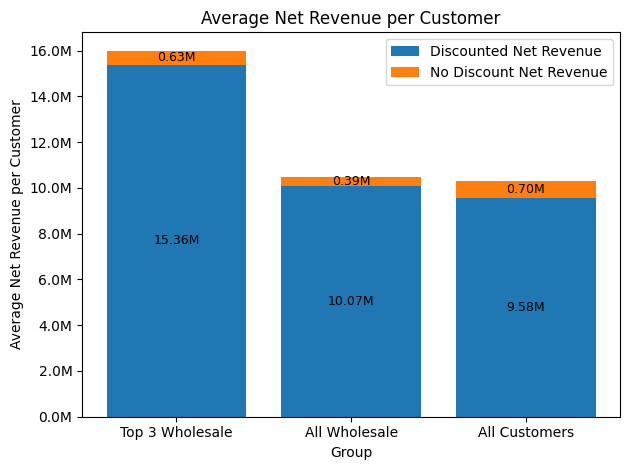

In [23]:
plt.figure()

x = compare_df["group"].tolist()
discounted = compare_df["discounted_net_revenue"].tolist()
no_discount = compare_df["no_discount_net_revenue"].tolist()

ax = plt.gca()
ax.bar(x, discounted, label="Discounted Net Revenue")  # bottom
ax.bar(x, no_discount, bottom=discounted, label="No Discount Net Revenue")  # top

ax.set_title("Average Net Revenue per Customer")
ax.set_xlabel("Group")
ax.set_ylabel("Average Net Revenue per Customer")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda v, _: f"{v/1_000_000:.1f}M"))

for i, (b, t) in enumerate(zip(discounted, no_discount)):
    if b:
        ax.text(i, b/2, f"{b/1_000_000:.2f}M", ha="center", va="center", fontsize=9)
    if t:
        ax.text(i, b + t/2, f"{t/1_000_000:.2f}M", ha="center", va="center", fontsize=9)

ax.legend()
plt.tight_layout()
plt.show()


The top three wholesale customers generate 96.06% of their net revenue through discounted sales. This proportion is close to the overall wholesale pattern and slightly higher than the average observed across all customers. This indicates that wholesale customers, including the highest impact accounts, tend to rely more heavily on discounting than the broader customer base.

In [24]:
# Monthly average Net Revenue per customer (Top 3 Wholesale vs All Wholesale vs overall)
top3_ids = top3_wholesale["customer_id"].tolist()

monthly_overall_avg = con.execute("""
SELECT
    date_trunc('month', sale_date) AS month,
    SUM(net_revenue) / COUNT(DISTINCT customer_id) AS avg_net_revenue_per_customer
FROM sales
WHERE sale_date IS NOT NULL
GROUP BY month
ORDER BY month
""").df()

monthly_all_wholesale_avg = con.execute("""
SELECT
    date_trunc('month', sale_date) AS month,
    SUM(net_revenue) / COUNT(DISTINCT customer_id) AS avg_net_revenue_per_customer
FROM sales
WHERE sale_date IS NOT NULL
  AND customer_type = 'Wholesale'
GROUP BY month
ORDER BY month
""").df()

monthly_top3_avg = con.execute("""
SELECT
    date_trunc('month', sale_date) AS month,
    SUM(net_revenue) / 3.0 AS avg_net_revenue_per_customer
FROM sales
WHERE sale_date IS NOT NULL
  AND customer_id IN (?, ?, ?)
GROUP BY month
ORDER BY month
""", top3_ids).df()

# Merge to a consistent timeline and fill missing values with 0 to avoid gaps
wh_time_df = (
    monthly_overall_avg
    .merge(monthly_all_wholesale_avg, on="month", how="left", suffixes=("_overall", "_all_wholesale"))
    .merge(monthly_top3_avg, on="month", how="left")
    .sort_values("month")
)

wh_time_df = wh_time_df.rename(columns={"avg_net_revenue_per_customer": "avg_net_revenue_per_customer_top3_wholesale"})
wh_time_df["avg_net_revenue_per_customer_all_wholesale"] = wh_time_df["avg_net_revenue_per_customer_all_wholesale"].fillna(0)
wh_time_df["avg_net_revenue_per_customer_top3_wholesale"] = wh_time_df["avg_net_revenue_per_customer_top3_wholesale"].fillna(0)

wh_time_df


,month,avg_net_revenue_per_customer_overall,avg_net_revenue_per_customer_all_wholesale,avg_net_revenue_per_customer_top3_wholesale
0,2024-01-01,1.585169e+06,1.721864e+06,9.602667e+05
1,2024-02-01,1.693832e+06,1.475355e+06,2.243333e+06
2,2024-03-01,1.484776e+06,1.716020e+06,1.561400e+06
3,2024-04-01,1.122613e+06,1.437418e+06,1.511867e+06
4,2024-05-01,1.927340e+06,1.633047e+06,1.672367e+06
5,2024-06-01,1.596854e+06,1.119850e+06,0.000000e+00
6,2024-07-01,1.454396e+06,1.515125e+06,1.174067e+06
7,2024-08-01,1.622790e+06,1.374467e+06,5.435000e+05
8,2024-09-01,1.549602e+06,1.541489e+06,1.553167e+06
9,2024-10-01,1.524728e+06,1.735891e+06,1.299967e+06


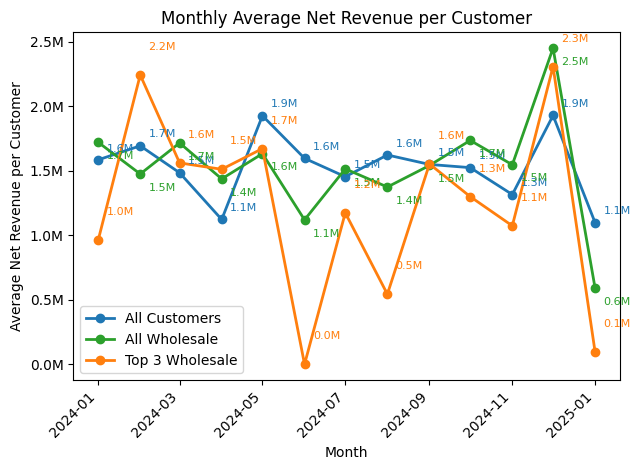

In [25]:
plt.figure()

# Colors
color_all_customers = "tab:blue"
color_top3 = "tab:orange"
color_all_wholesale = "tab:green"

# All Customers
plt.plot(
    wh_time_df["month"],
    wh_time_df["avg_net_revenue_per_customer_overall"],
    label="All Customers",
    color=color_all_customers,
    marker="o",
    linewidth=2,
    zorder=2
)

# All Wholesale
plt.plot(
    wh_time_df["month"],
    wh_time_df["avg_net_revenue_per_customer_all_wholesale"],
    label="All Wholesale",
    color=color_all_wholesale,
    marker="o",
    linewidth=2,
    zorder=2
)

# Top 3 Wholesale
plt.plot(
    wh_time_df["month"],
    wh_time_df["avg_net_revenue_per_customer_top3_wholesale"],
    label="Top 3 Wholesale",
    color=color_top3,
    marker="o",
    linewidth=2,
    zorder=3
)

plt.title("Monthly Average Net Revenue per Customer")
plt.xlabel("Month")
plt.ylabel("Average Net Revenue per Customer")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda v, _: f"{v/1_000_000:.1f}M"))
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()

# Annotate points (in M)
for x_val, y_val in zip(wh_time_df["month"], wh_time_df["avg_net_revenue_per_customer_overall"]):
    if pd.notna(y_val):
        plt.annotate(fmt_m(y_val), (x_val, y_val), textcoords="offset points", xytext=(6, 6), fontsize=8, color=color_all_customers)

for x_val, y_val in zip(wh_time_df["month"], wh_time_df["avg_net_revenue_per_customer_all_wholesale"]):
    if pd.notna(y_val):
        plt.annotate(fmt_m(y_val), (x_val, y_val), textcoords="offset points", xytext=(6, -12), fontsize=8, color=color_all_wholesale)

for x_val, y_val in zip(wh_time_df["month"], wh_time_df["avg_net_revenue_per_customer_top3_wholesale"]):
    if pd.notna(y_val):
        plt.annotate(fmt_m(y_val), (x_val, y_val), textcoords="offset points", xytext=(6, 18), fontsize=8, color=color_top3)

plt.show()


Across the monthly series, the average net revenue per customer for all customers, all wholesale, and top 3 wholesale follows a very similar pattern over time, with values remaining close to one another throughout most months.

Minor deviations are observed for the top 3 wholesale group. A slightly higher value appears in February 2024, while lower values are observed in January 2024 and August 2024. One month deserves special attention: June 2024, when the top 3 wholesale group records zero net revenue per customer, a result substantially below both all wholesale and all customers during the same period.

## Cross-Section Correlations

Across the different analytical layers (Products, Stores, Employees, Customers, Temporal trends, and the Wholesale focus) a consistent global pattern emerges: net revenue is structurally driven by discounted transactions throughout the dataset.

While this discount dependency is clearly global, the most informative differences appear in how strongly individual products deviate from this dominant pattern across specific contexts. These deviations are not random. Certain products, most notably P015, repeatedly emerge as outliers across multiple analytical layers, including product level, store level, and employee level views. This recurrence indicates product specific commercial behavior rather than isolated anomalies.

Importantly, the granular perspective does not contradict the global pattern but refines it. At aggregate levels, stores and employees appear largely uniform in their reliance on discounts. However, when the analysis moves to product–store and product–employee intersections, variations in discount intensity become more pronounced. These granular differences represent changes in magnitude within a single discount driven regime, rather than distinct or opposing revenue behaviors.

Customer level findings reinforce this interpretation. Although Wholesale customers show a slightly higher share of discounted net revenue, their average net revenue per customer remains comparable to retail and online segments. This suggests that higher transaction volumes or wholesale classification alone do not fundamentally alter the underlying discount driven structure.

The temporal analysis provides a unifying perspective across sections. Monthly net revenue and discounted sales counts exhibit similar variation patterns over time, with peak periods amplifying the existing discount dependent behavior rather than introducing new dynamics.

Together, these cross sectional observations confirm that discount reliance is a structural characteristic of the dataset, with meaningful but gradual variations emerging only at specific product context intersections.


## Interactive Dashboard

To complement the analysis presented, an interactive dashboard was developed. The dashboard provides an exploratory view of the metrics and dimensions analyzed, allowing users to dynamically examine Gross Revenue, Net Revenue, discount behavior, and Average Order Value across stores, time, and discount ranges.

https://public.tableau.com/views/RetailCo-DiscountImpactonReveneu/RetailCo-DiscountImpactonReveneu?:language=pt-BR&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link


## Key Insights

The primary insight of this analysis is that net revenue in RetailCo is structurally dependent on discounts across all analyzed dimensions, rather than being driven by isolated products, stores, employees, or customer segments.

Deviations from this dominant pattern are not random but consistently concentrate in specific products, most notably P015, which repeatedly appears as an outlier across multiple analytical perspectives.

While discount dependency is global, meaningful variation emerges in the intensity of this dependency at granular levels, particularly within specific product–store and product–employee combinations.

The product catalog follows a single discount driven regime, with variations in discount intensity rather than distinct behavioral profiles, as discounted transactions remain the primary revenue source even for less discount dependent products.

Although wholesale customers present a slightly higher discounted share, their average net revenue per customer does not materially exceed retail or online segments, contradicting the initial expectation of higher per customer revenue in wholesale transactions.

## Practical Applications

Prioritize discount review at the product context level (product–store and product–employee) rather than broad, store wide or employee wide adjustments.

Use recurring outliers such as P015 to investigate where discounts are truly necessary versus where revenue can be sustained with lower discount intensity.

Avoid assuming that wholesale classification alone guarantees higher average customer value, and instead prioritize analysis of product mix and discount application to explain customer level performance.

Leverage temporal peaks to validate discount effectiveness, recognizing that periods of higher net revenue tend to amplify existing discount driven mechanisms rather than introduce new revenue dynamics.

The most important insight of this analysis is that net revenue in RetailCo is structurally dependent on discounts across all analyzed dimensions, rather than being driven by isolated products, stores, employees, or customer segments.

The results of this analysis are particularly relevant for pricing and sales operations contexts.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5562491b-a98e-4925-a811-76400f1e61c7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>